

## Granularity
Granularity of predictions is one planet.
For each planet we need to predict `283` `spectras` (float number) for corresponding wave lengths and each with an associated uncertainty `sigma`.

## Data
For each planet we have:
- **FGS1** signal (`FGS1_signal_0.parquet`) `[135000, 32 * 32]` (`135000` time steps, each representing `0.1` seconds and `32*32` is sensor data) 
- **AIRS-CH0** signal (`AIRS-CH0_signal_0.parquet`) `[11250, 32 * 356]` (`11250` time steps, each representing `1.2` seconds and `32*356` is sensor data `32` spatial and `356` different wave lengths)

Also we have additional calibration data to make raw data from sensors more informative.

## Baseline overview
    
### Preprocessing
* Calibration of raw signal. It consists of scaling the signal, eliminating dead pixels and other complicated techniques [calibration discussion](https://www.kaggle.com/competitions/ariel-data-challenge-2024/discussion/528066). Only `40-321` wave_length positions (they should relate to `2-283` positions in targets) are taken for **AIRS-CH0**
* Calibrated signal is divided into time chunks and aggregated (mean). It reduces number of time points and we get
  `[187, 32, 32]` for **FGS1** (`187` time steps) and `[187, 32, 282]` for **AIRS-CH0** (`187` time steps)
* Only center spatial pixels are taken and get `[187, 12, 12]` for **FGS1** and `[187, 12, 282]` for **AIRS-CH0**
* Aggregate (mean) sensor data per special dimension. We get `[187, 1]` for **FGS1** and `[187, 282]` for **AIRS-CH0**
* Concatenate **FGS1** and **AIRS-CH0** to `[187, 283]` array. Let's call it a `preprocessed_signal`

### Spectra prediction
* Aggregate (mean) of our `preprocessed_signal` for `2-283` wave_length positions and get `[187]` data points (time dimension) as an input to further optimizations
* Find time points `phase1` and `phase2` - start and end of planet going in front of the star (`phase_detector`)
* Next we need to find a constant `s` (actually our further prediction of `spectra`) that after multiplication
`signal[phase1:phase2] * (1 + s)` we can't see a "step" in the signal (more formally, the error after fitting 3nd power polynomial is minimal)

An exmaple for planet signal phases is demonstrated at the image
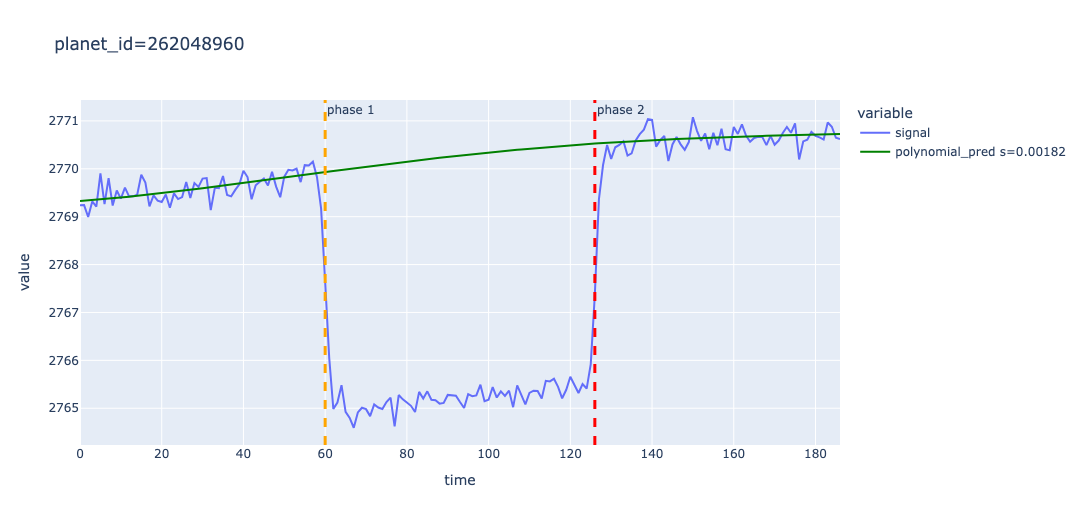
* We just predict the same `s` for all different spectras (`283`)
* Sigma is just a constant `0.00127` for all spectras and all planets
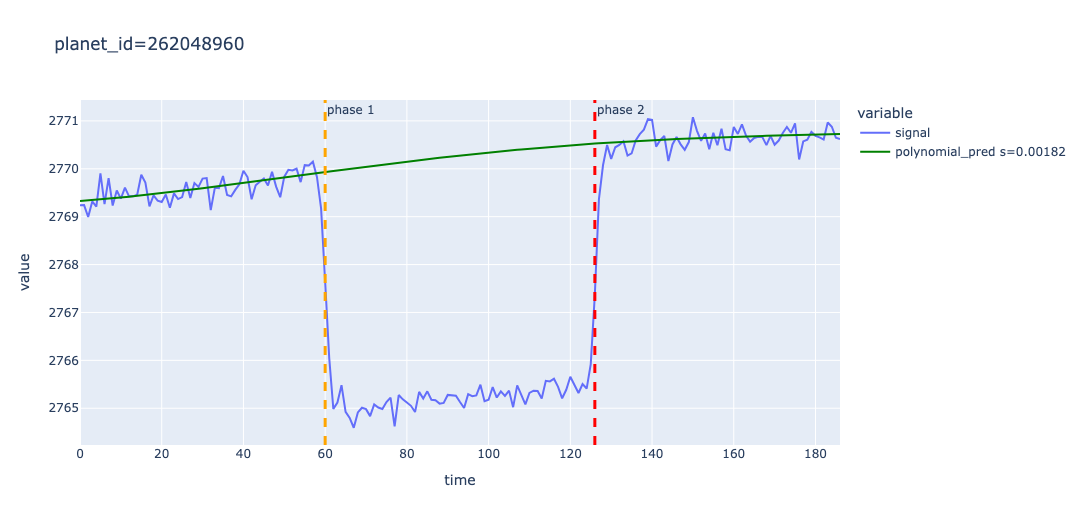

In [1]:
# install pqdm for parallel processing
!pip install --no-index --find-links=/kaggle/input/ariel-2024-pqdm pqdm

Looking in links: /kaggle/input/ariel-2024-pqdm
Processing /kaggle/input/ariel-2024-pqdm/pqdm-0.2.0-py2.py3-none-any.whl
Processing /kaggle/input/ariel-2024-pqdm/bounded_pool_executor-0.0.3-py3-none-any.whl (from pqdm)


# Librairies

In [2]:
import pandas as pd
import numpy as np
import pandas.api.types
import scipy.stats

from tqdm import tqdm
from pqdm.threads import pqdm
import itertools
import pickle

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import plotly.express as px

from astropy.stats import sigma_clip
from scipy.signal import savgol_filter

# Config

In [3]:
class Config:
    DATA_PATH = '/kaggle/input/ariel-data-challenge-2025'
    DATASET = "test"

    SCALE = 0.95
    SIGMA = 0.0009
    
    CUT_INF = 39
    CUT_SUP = 250
    
    SENSOR_CONFIG = {
        "AIRS-CH0": {
            "raw_shape": [11250, 32, 356],
            "calibrated_shape": [1, 32, CUT_SUP - CUT_INF],
            "linear_corr_shape": (6, 32, 356),
            "dt_pattern": (0.1, 4.5), 
            "binning": 30
        },
        "FGS1": {
            "raw_shape": [135000, 32, 32],
            "calibrated_shape": [1, 32, 32],
            "linear_corr_shape": (6, 32, 32),
            "dt_pattern": (0.1, 0.1),
            "binning": 30 * 12
        }
    }
    
    MODEL_PHASE_DETECTION_SLICE = slice(30, 140)
    MODEL_OPTIMIZATION_DELTA = 7
    MODEL_POLYNOMIAL_DEGREE = 3
    
    N_JOBS = 4

# SignalProcessor

In [4]:
class SignalProcessor:
    def __init__(self, config):
        self.cfg = config
        self.adc_info = pd.read_csv(f"{self.cfg.DATA_PATH}/adc_info.csv")
        self.planet_ids = pd.read_csv(f'{self.cfg.DATA_PATH}/{self.cfg.DATASET}_star_info.csv', index_col='planet_id').index.astype(int)

    def _apply_linear_corr(self, linear_corr, signal):
        linear_corr_flipped = np.flip(linear_corr, axis=0)
        corrected_signal = signal.copy()
        
        for x, y in itertools.product(range(signal.shape[1]), range(signal.shape[2])):
            poly = np.poly1d(linear_corr_flipped[:, x, y])
            corrected_signal[:, x, y] = poly(corrected_signal[:, x, y])
            
        return corrected_signal

    def _calibrate_single_signal(self, planet_id, sensor):
        sensor_cfg = self.cfg.SENSOR_CONFIG[sensor]

        signal = pd.read_parquet(f"{self.cfg.DATA_PATH}/{self.cfg.DATASET}/{planet_id}/{sensor}_signal_0.parquet").to_numpy()
        dark = pd.read_parquet(f"{self.cfg.DATA_PATH}/{self.cfg.DATASET}/{planet_id}/{sensor}_calibration_0/dark.parquet").to_numpy()
        dead = pd.read_parquet(f"{self.cfg.DATA_PATH}/{self.cfg.DATASET}/{planet_id}/{sensor}_calibration_0/dead.parquet").to_numpy()
        flat = pd.read_parquet(f"{self.cfg.DATA_PATH}/{self.cfg.DATASET}/{planet_id}/{sensor}_calibration_0/flat.parquet").to_numpy()
        linear_corr = pd.read_parquet(f"{self.cfg.DATA_PATH}/{self.cfg.DATASET}/{planet_id}/{sensor}_calibration_0/linear_corr.parquet").values.astype(np.float64).reshape(sensor_cfg["linear_corr_shape"])

        signal = signal.reshape(sensor_cfg["raw_shape"])
        gain = self.adc_info[f"{sensor}_adc_gain"].iloc[0]
        offset = self.adc_info[f"{sensor}_adc_offset"].iloc[0]
        signal = signal / gain + offset

        hot = sigma_clip(dark, sigma=5, maxiters=5).mask

        if sensor == "AIRS-CH0":
            signal = signal[:, :, self.cfg.CUT_INF : self.cfg.CUT_SUP]
            linear_corr = linear_corr[:, :, self.cfg.CUT_INF : self.cfg.CUT_SUP]
            dark = dark[:, self.cfg.CUT_INF : self.cfg.CUT_SUP]
            dead = dead[:, self.cfg.CUT_INF : self.cfg.CUT_SUP]
            flat = flat[:, self.cfg.CUT_INF : self.cfg.CUT_SUP]
            hot = hot[:, self.cfg.CUT_INF : self.cfg.CUT_SUP]
        
        base_dt, increment = sensor_cfg["dt_pattern"]
        dt = np.ones(len(signal)) * base_dt
        dt[1::2] += increment
        
        signal = signal.clip(0)
        signal = self._apply_linear_corr(linear_corr, signal)
        signal -= dark * dt[:, np.newaxis, np.newaxis]
        
        flat = flat.reshape(sensor_cfg["calibrated_shape"])
        flat[dead.reshape(sensor_cfg["calibrated_shape"])] = np.nan
        flat[hot.reshape(sensor_cfg["calibrated_shape"])] = np.nan
        
        signal = signal / flat
        
        return signal

    def _preprocess_calibrated_signal(self, calibrated_signal, sensor):
        sensor_cfg = self.cfg.SENSOR_CONFIG[sensor]
        binning = sensor_cfg["binning"]

        if sensor == "AIRS-CH0":
            signal_roi = calibrated_signal[:, 10:22, :]
        elif sensor == "FGS1":
            signal_roi = calibrated_signal[:, 10:22, 10:22]
            signal_roi = signal_roi.reshape(signal_roi.shape[0], -1)
        
        mean_signal = np.nanmean(signal_roi, axis=1)

        cds_signal = mean_signal[1::2] - mean_signal[0::2]

        n_bins = cds_signal.shape[0] // binning
        binned = np.array([
            cds_signal[j*binning : (j+1)*binning].mean(axis=0) 
            for j in range(n_bins)
        ])

        if sensor == "FGS1":
            binned = binned.reshape((binned.shape[0], 1))
            
        return binned

    def _process_planet_sensor(self, args):
        planet_id, sensor = args['planet_id'], args['sensor']
        calibrated = self._calibrate_single_signal(planet_id, sensor)
        preprocessed = self._preprocess_calibrated_signal(calibrated, sensor)
        return preprocessed

    def process_all_data(self):
        args_fgs1 = [dict(planet_id=planet_id, sensor="FGS1") for planet_id in self.planet_ids]
        preprocessed_fgs1 = pqdm(args_fgs1, self._process_planet_sensor, n_jobs=self.cfg.N_JOBS)

        args_airs_ch0 = [dict(planet_id=planet_id, sensor="AIRS-CH0") for planet_id in self.planet_ids]
        preprocessed_airs_ch0 = pqdm(args_airs_ch0, self._process_planet_sensor, n_jobs=self.cfg.N_JOBS)

        preprocessed_signal = np.concatenate(
            [np.stack(preprocessed_fgs1), np.stack(preprocessed_airs_ch0)], axis=2
        )
        return preprocessed_signal

# TransitModel

In [5]:
class TransitModel:
    def __init__(self, config):
        self.cfg = config

    def _phase_detector(self, signal):
        search_slice = self.cfg.MODEL_PHASE_DETECTION_SLICE
        min_index = np.argmin(signal[search_slice]) + search_slice.start
        
        signal1 = signal[:min_index]
        signal2 = signal[min_index:]

        grad1 = np.gradient(signal1)
        grad1 /= grad1.max()
        
        grad2 = np.gradient(signal2)
        grad2 /= grad2.max()

        phase1 = np.argmin(grad1)
        phase2 = np.argmax(grad2) + min_index

        return phase1, phase2
    
    def _objective_function(self, s, signal, phase1, phase2):
        delta = self.cfg.MODEL_OPTIMIZATION_DELTA
        power = self.cfg.MODEL_POLYNOMIAL_DEGREE

        if phase1 - delta <= 0 or phase2 + delta >= len(signal) or phase2 - delta - (phase1 + delta) < 5:
            delta = 2

        y = np.concatenate([
            signal[: phase1 - delta],
            signal[phase1 + delta : phase2 - delta] * (1 + s),
            signal[phase2 + delta :]
        ])
        x = np.arange(len(y))

        coeffs = np.polyfit(x, y, deg=power)
        poly = np.poly1d(coeffs)
        error = np.abs(poly(x) - y).mean()
        
        return error

    def predict(self, single_preprocessed_signal):
        signal_1d = single_preprocessed_signal[:, 1:].mean(axis=1)
        signal_1d = savgol_filter(signal_1d, 20, 2)
        
        phase1, phase2 = self._phase_detector(signal_1d)

        phase1 = max(self.cfg.MODEL_OPTIMIZATION_DELTA, phase1)
        phase2 = min(len(signal_1d) - self.cfg.MODEL_OPTIMIZATION_DELTA - 1, phase2)    

        result = minimize(
            fun=self._objective_function,
            x0=[0.0001],
            args=(signal_1d, phase1, phase2),
            method="Nelder-Mead"
        )
        
        return result.x[0]

    def predict_all(self, preprocessed_signals):
        predictions = [
            self.predict(preprocessed_signal)
            for preprocessed_signal in tqdm(preprocessed_signals)
        ]
        return np.array(predictions) * self.cfg.SCALE

# SubmissionGenerator

In [6]:
class SubmissionGenerator:
    def __init__(self, config):
        self.cfg = config
        self.sample_submission = pd.read_csv(f"{self.cfg.DATA_PATH}/sample_submission.csv", index_col="planet_id")
        

    def create(self, predictions):
        planet_ids = self.sample_submission.index
        repeated_predictions = np.repeat(predictions, self.sample_submission.shape[1] // 2).reshape(len(predictions), -1)
        repeated_predictions = repeated_predictions.clip(0)
        
        sigmas = np.ones_like(repeated_predictions) * self.cfg.SIGMA

        submission_df = pd.DataFrame(
            np.concatenate([repeated_predictions, sigmas], axis=1),
            columns=self.sample_submission.columns,
            index=planet_ids
        )
        
        submission_df.to_csv("submission.csv")
        return submission_df

# Run

In [7]:
config = Config()
    
signal_processor = SignalProcessor(config)
preprocessed_data = signal_processor.process_all_data()

model = TransitModel(config)
predictions = model.predict_all(preprocessed_data)

submission_generator = SubmissionGenerator(config)
submission = submission_generator.create(predictions)

submission

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
1103775,0.016335,0.016335,0.016335,0.016335,0.016335,0.016335,0.016335,0.016335,0.016335,0.016335,...,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009
